<a href="https://colab.research.google.com/github/ktjylsj/save/blob/master/MobileNetV2_x_Factory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Factory Abnormal detector Training Environment

We will perform the image classification on **Factory datasets** using a **custom MobileNetV2** based on Keras.

<br></br>
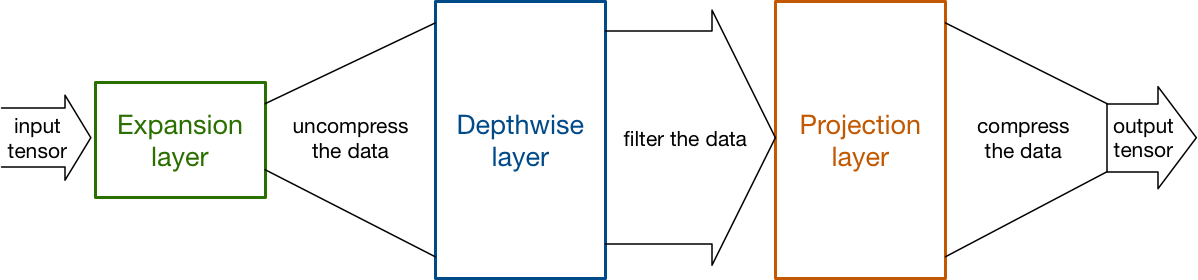

<br></br>
For more information on MobileNetV2, please check [this article](http://machinethink.net/blog/mobilenet-v2/).

## Upload training datasets

Zipped Directory structure
---
    /images
        /circle
            /<image #0>.jpg
            /<image #1>.jpg
            /<image #2>.jpg
            /...
        /x
            /<image #0>.jpg
            /<image #1>.jpg
            /<image #2>.jpg
            /...

In [ ]:
from google.colab import files

uploaded = files.upload()

name = next(iter(uploaded))

! unzip -q -o {name}

Saving images.zip to images.zip


## Training Abnormal detector by using MobileNetV2 in Keras

MobileNet-V2 accepts one of the following formats and the image has to be 3 channel (RGB).

* (96, 96)
* (128, 128)
* (160, 160)
* (192, 192)
* (224, 224)

It is required to convert the label data to one hot encoded format.

In [ ]:
from glob import glob
from random import shuffle

import cv2
import numpy as np
from keras.layers import Dense, Dropout, Input
from keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.utils import to_categorical


# prepare data feeder for keras model
def train_generator(batch_size=64):
    paths = glob("images/*/*.jpg")
    shuffle(paths)

    while True:
        for i in range(0, len(paths), batch_size):
            data = []
            label = []

            for path in paths[i:i + batch_size]:
                bgr = cv2.imread(path)
                rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

                preprocessed = ((rgb.astype(np.float32) / 255.0) - 0.5) * 2

                data.append(preprocessed)
                label.append([0., 1.] if 'circle' in path else [1., 0.])

            yield np.array(data), np.array(label)


model_name = "factory_mobilenetv2"
input_size = 224
input_shape = (input_size, input_size, 3)

# Input
input_tensor = Input(shape=input_shape)

# Base
base_model = MobileNetV2(include_top=False,
                         input_tensor=input_tensor,
                         input_shape=input_shape,
                         pooling='avg')

for layer in base_model.layers:
    layer.trainable = True

# Output
layer = Dense(256, activation='relu')(base_model.output)
layer = Dropout(.25)(layer)
output_tensor = Dense(2, activation='softmax')(layer)

# Build custom model
model = Model(inputs=input_tensor, outputs=output_tensor, name=model_name)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

# check our model
model.summary()


9420800/9406464 [==============================] - 0s 0us/step
Model: "factory_mobilenetv2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                 

In [ ]:
# Actual training
model.fit(train_generator(), steps_per_epoch=100, epochs=2)

model.save(f"{model_name}.h5")

Epoch 1/2
100/100 [==============================] - 78s 623ms/step - loss: 0.0169 - categorical_accuracy: 0.9909
Epoch 2/2
100/100 [==============================] - 61s 609ms/step - loss: 5.4338e-07 - categorical_accuracy: 1.0000


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


## Test training result

In [ ]:
test_files = ['./images/circle/frame001.jpg', './images/x/frame010.jpg']

label = ['X', 'Circle']

for path in test_files:
    bgr = cv2.imread(path)
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

    preprocessed = ((rgb.astype(np.float32) / 255.0) - 0.5) * 2
    nhwc = preprocessed[np.newaxis, :, :, :]  # HWC to NHWC

    predictions = model(nhwc)

    # print output
    idx = np.argmax(predictions)
    print(" * Result:", path, ':', label[idx])

 * Result: ./images/circle/frame001.jpg : Circle
 * Result: ./images/x/frame010.jpg : X


## Convert to PB file

### Freeze the graph to a single TensorFlow .pb file

It is not able to convert Keras H5 files directly by running the Openvino model optimizer. <br />
You need to convert the Keras **H5** to the TensorFlow **PB** file first.

In [ ]:
import tensorflow as tf
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

# Convert Keras model to ConcreteFunction
full_model = tf.function(lambda x: model(x)).get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype))

# Get frozen ConcreteFunction
frozen_func = convert_variables_to_constants_v2(full_model)
frozen_func.graph.as_graph_def()

# Save frozen graph to disk
saved_file = tf.io.write_graph(graph_or_graph_def=frozen_func.graph,
                  logdir='',
                  name=f"{model_name}.pb",
                  as_text=False)

!ls -lh "{saved_file}"

-rw-r--r-- 1 root root 11M Dec  2 08:52 factory_mobilenetv2.pb


# Install Intel OpenVINO

You can download the installation binary from [Intel OpenVINO Download](https://software.intel.com/content/www/us/en/develop/tools/openvino-toolkit/download.html) page.

For this example, choose the option below to download the binary.

* Operating System:  **Linux**
* Distribution: **Web and Local Install**
* Installer Type: **Local**

In [ ]:
! rm l_openvino_toolkit_p_*.tgz
! wget -nc https://registrationcenter-download.intel.com/akdlm/irc_nas/18319/l_openvino_toolkit_p_2021.4.752.tgz
! tar xf l_openvino_toolkit_p_2021.4.752.tgz

## install required tools
!sudo apt-get install -y pciutils cpio
!sudo apt autoremove

## install openvino
! cd l_openvino_toolkit_p_2021.4.752 && \
  ./install_openvino_dependencies.sh && \
  sed -i 's/decline/accept/g' silent.cfg && \
  ./install.sh --silent silent.cfg

## install dependencies
!/opt/intel/openvino_2021/install_dependencies/install_openvino_dependencies.sh

## install prerequisites
!/opt/intel/openvino_2021/deployment_tools/model_optimizer/install_prerequisites/install_prerequisites.sh

rm: cannot remove 'l_openvino_toolkit_p_*.tgz': No such file or directory
--2021-12-02 08:52:08--  https://registrationcenter-download.intel.com/akdlm/irc_nas/18319/l_openvino_toolkit_p_2021.4.752.tgz
Resolving registrationcenter-download.intel.com (registrationcenter-download.intel.com)... 104.116.243.18, 104.116.243.17
Connecting to registrationcenter-download.intel.com (registrationcenter-download.intel.com)|104.116.243.18|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 638789338 (609M) [application/octet-stream]
Saving to: ‘l_openvino_toolkit_p_2021.4.752.tgz’

l_openvino_toolkit_ 100%[===================>] 609.20M  67.8MB/s    in 9.7s    

2021-12-02 08:52:18 (62.6 MB/s) - ‘l_openvino_toolkit_p_2021.4.752.tgz’ saved [638789338/638789338]

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libpci3
Suggested packages:
  libarchive1
The following NEW packages 

## Run the demo to see whether the installation process was successful

In [ ]:
%%time

! source /opt/intel/openvino_2021/bin/setupvars.sh && \
  /opt/intel/openvino_2021/deployment_tools/demo/demo_squeezenet_download_convert_run.sh

[setupvars.sh] OpenVINO environment initialized
target_precision = FP16
[setupvars.sh] OpenVINO environment initialized


###################################################



Installing dependencies
Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:8 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:12 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get

# OpenVINO model optimization

## Perform OpenVINO model optimizer (MO)

In [ ]:
input_shape = [1, input_size, input_size, 3]
input_shape_str = str(input_shape).replace(' ','')

! source /opt/intel/openvino_2021/bin/setupvars.sh && \
  python3 /opt/intel/openvino_2021/deployment_tools/model_optimizer/mo_tf.py \
    --input_model "{model_name}.pb" \
    --output_dir 'model' \
    --input_shape {input_shape_str} \
    --data_type FP32

!ls -lh model

[setupvars.sh] OpenVINO environment initialized
Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	/content/factory_mobilenetv2.pb
	- Path for generated IR: 	/content/model
	- IR output name: 	factory_mobilenetv2
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	[1,224,224,3]
	- Mean values: 	Not specified
	- Scale values: 	Not specified
	- Scale factor: 	Not specified
	- Precision of IR: 	FP32
	- Enable fusing: 	True
	- Enable grouped convolutions fusing: 	True
	- Move mean values to preprocess section: 	None
	- Reverse input channels: 	False
TensorFlow specific parameters:
	- Input model in text protobuf format: 	False
	- Path to model dump for TensorBoard: 	None
	- List of shared libraries with TensorFlow custom layers implementation: 	None
	- Update the configuration file with input/output node names: 	N

## Test Openvino output file

Sample code

In [ ]:
%%writefile app.py

import cv2
import numpy as np
from openvino.inference_engine import IECore

# initialize Inference Engine (IE)
ie = IECore()

# read model and prepare network
net = ie.read_network(model="./model/factory_mobilenetv2.xml")

# create executable network
exec_net = ie.load_network(network=net,
                           device_name="CPU",
                           num_requests=1)

input_name = next(iter(net.input_info))
out_name = next(iter(net.outputs))

# Run infer
label = ['X', 'Circle']

bgr = cv2.imread('./images/x/frame010.jpg')
rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

preprocessed = ((rgb.astype(np.float32) / 255.0) - 0.5) * 2
nhwc = preprocessed[np.newaxis, :, :, :]  # HWC to NHWC
nchw = nhwc.transpose((0, 3, 1, 2))  # NHWC to NCHW

res = exec_net.infer(inputs={input_name: nchw})
predict = res[out_name][0]

x_ratio = np.float32(predict[0]) * 100.
circle_ratio = np.float32(predict[1]) * 100.

print(f"X = {x_ratio:.2f}%, Circle = {circle_ratio:.2f}%")

Writing app.py


Run python script under OpenVINO environment

In [ ]:
! source /opt/intel/openvino_2021/bin/setupvars.sh && \
  python app.py

[setupvars.sh] OpenVINO environment initialized
X = 99.56%, Circle = 0.44%


## Download OpenVINO files

In [ ]:
! zip -r model.zip model
files.download('model.zip')

  adding: model/ (stored 0%)
  adding: model/factory_mobilenetv2.bin (deflated 7%)
  adding: model/factory_mobilenetv2.mapping (deflated 97%)
  adding: model/factory_mobilenetv2.xml (deflated 95%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>